In [1]:
# Sample API
import flowx
import simulation
import numpy
flowx.__version__

'0.1.dev'

In [2]:
# Define grid parameters
nx, ny = 40, 40

xmin, xmax = 0.0, 2.0*numpy.pi
ymin, ymax = 0.0, 2.0*numpy.pi

# Define cell-centered variable names
center_vars = ['pres', 'divp', 'divc','asol','eror']
face_vars   = ['velc', 'hvar','asol','eror']

# Define boundary conditions for variable pressure and velocity [left, right, bottom, top]
bc_type_pres = {'pres': ['neumann', 'neumann', 'neumann', 'neumann']}
bc_val_pres  = {'pres': [0.0, 0.0, 0.0, 0.0]}

bc_type_u = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_u  = {'velc': [0.0, 0.0, 0.0, 0.0]}

bc_type_v = {'velc': ['dirichlet', 'dirichlet', 'dirichlet', 'dirichlet']}
bc_val_v  = {'velc': [0.0, 0.0, 0.0, 0.0]}


# Create the grid and data
gridc = flowx.Grid('cell-centered', center_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_pres, user_bc_val=bc_val_pres)

gridx = flowx.Grid('x-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_u, user_bc_val=bc_val_u)

gridy = flowx.Grid('y-face', face_vars,
                    nx, ny, xmin, xmax, ymin, ymax,
                    user_bc_type=bc_type_v, user_bc_val=bc_val_v)

scalars = flowx.Scalars(tmax=2, dt=0.0001, Re=1.0)

simulation.update_bc_val(gridx, gridy, 'velc', scalars.to)

In [3]:
simulation.get_initial(gridc, gridx, gridy, 'velc', 'pres')

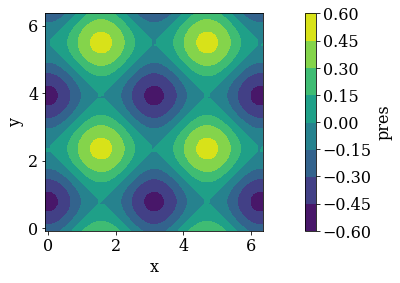

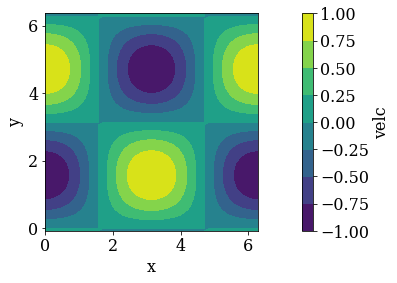

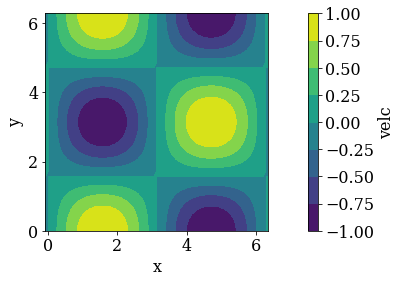

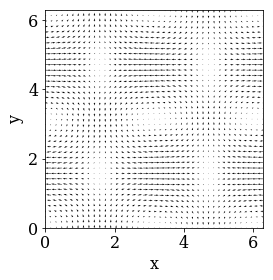

In [4]:
flowx.io.plot_contour(gridc, 'pres')
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridy, 'velc')
flowx.io.plot_vector(gridx, gridy, 'velc')

In [5]:
while scalars.time <= scalars.tmax:
    
    # Update the time-dependent boundary condition value
    simulation.update_bc_val(gridx, gridy, 'velc', scalars.time)
    
    # Calculate predicted velocity: u* = dt*H(u^n)
    flowx.ins.predictor(gridx, gridy, 'velc', 'hvar', scalars.Re, scalars.dt)
    
    # Calculate RHS for the pressure Poission solver div(u)/dt
    flowx.ins.divergence(gridc, gridx, gridy, 'velc', 'divp', ifac = scalars.dt)
    
    # Solve the pressure Poisson equation 
    scalars.stats['ites'], scalars.stats['res'] = flowx.poisson.solve_jacobi(gridc, 'pres', 'divp',
                                                                       maxiter=10000, tol=1e-9)
    
    # Calculate corrected velocity u^n+1 = u* - dt * grad(P) 
    flowx.ins.corrector(gridc, gridx, gridy, 'velc', 'pres', scalars.dt)
    
    # Calculate divergence of the corrected velocity to display stats
    flowx.ins.divergence(gridc, gridx, gridy, 'velc', 'divc')
    
    # Calculate stats
    scalars.stats.update(flowx.ins.stats(gridc, gridx, gridy, 'velc', 'pres', 'divc'))
    
    # Display stats
    if scalars.nstep % 10 == 0:
        flowx.io.display_stats(scalars.time, scalars.stats)   
    
    scalars.advance()

------------ Time = 0.0 ---------------
Number of poisson iterations    : 7417
Final poisson residual : 9.995717326234806e-10
Max, Min, U   : 0.9969173337331281, -0.996917333733128
Max, Min, V   : 0.996917333733128, -0.9969173337331281
Max, Min, P   : 1.4734081003573198, -1.487992108021264
Max, Min, DIV : 2.2339775862523226e-11, -2.2339810556992745e-11


------------ Time = 0.0010000000000000002 ---------------
Number of poisson iterations    : 323
Final poisson residual : 9.88667769058647e-10
Max, Min, U   : 0.9949254915717706, -0.9949254915717705
Max, Min, V   : 0.9949254915717705, -0.9949254915717706
Max, Min, P   : 0.48899263940705806, -0.48915338810127507
Max, Min, DIV : 2.9006685942079002e-11, -3.113727678472067e-11


------------ Time = 0.0020000000000000005 ---------------
Number of poisson iterations    : 322
Final poisson residual : 9.82886414274254e-10
Max, Min, U   : 0.9929376291137059, -0.9929376291137058
Max, Min, V   : 0.9929376291137058, -0.9929376291137059
Max, Min, P 

------------ Time = 0.021999999999999922 ---------------
Number of poisson iterations    : 314
Final poisson residual : 9.980927676552177e-10
Max, Min, U   : 0.954003987789395, -0.9540039877893949
Max, Min, V   : 0.9540039877893949, -0.954003987789395
Max, Min, P   : 0.4496879807504236, -0.4498420431517924
Max, Min, DIV : 3.011035865085887e-11, -3.3385752495895815e-11




KeyboardInterrupt: 

In [6]:
simulation.get_analytical(gridc, gridx, gridy, 'asol', scalars.time)

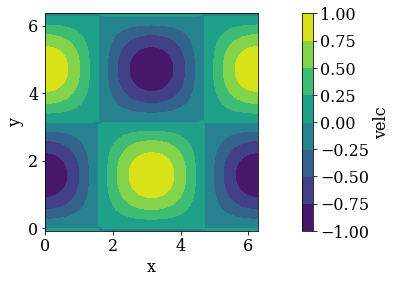

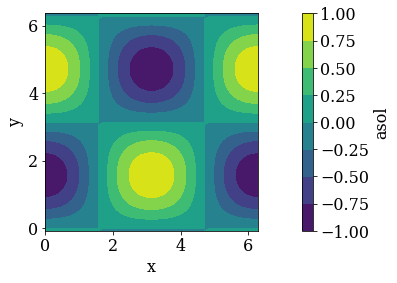

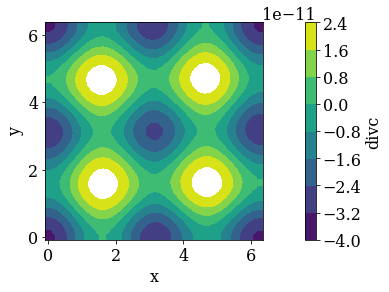

In [7]:
flowx.io.plot_contour(gridx, 'velc')
flowx.io.plot_contour(gridx, 'asol')
flowx.io.plot_contour(gridc, 'divc')

In [8]:
gridx.get_error('eror','velc','asol')
gridy.get_error('eror','velc','asol')

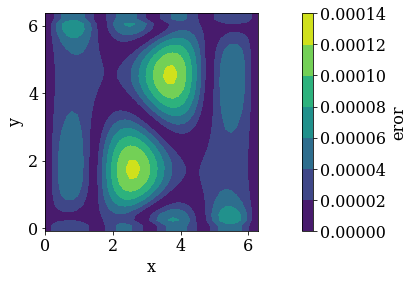

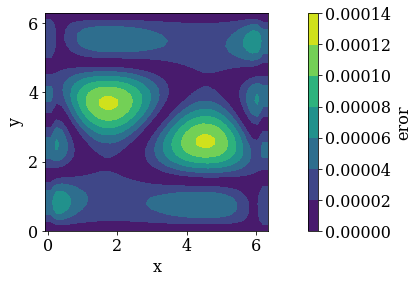

In [9]:
flowx.io.plot_contour(gridx, 'eror')
flowx.io.plot_contour(gridy, 'eror')